In [30]:
import gengli
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
from pycbc.noise import reproduceable
import pycbc.filter
from gengli.utils import compute_distance_matrix, metrics

srate = 4096

### Generaring glitches and computing the SNR

In [2]:
g = gengli.glitch_generator('L1')

In [3]:
# Randomly generated glitch
# What does the snr scaling of 15 mean?
# Is it something like it being 15 times
# that of the noise present in the glitch? 
glitch = g.get_glitch(1, snr=20, srate=srate)

In [4]:
glitch.shape

(938,)

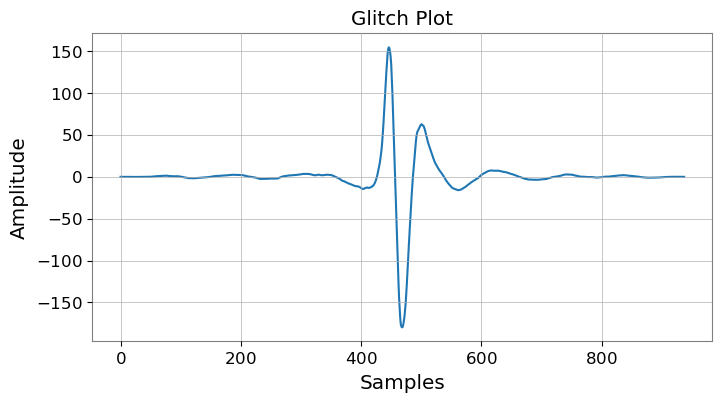

In [5]:
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(glitch)
plt.title('Glitch Plot')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

This here is a generated glitch which we will be inject into a white noise signal which is then used to obtain the SNR.

In [6]:
# White noise generator (kind of similar to a gaussian distribution).
# Generating 10 sec of noise at 4096 samples per second.
white_noise = reproduceable.normal(0, 10, sample_rate = srate)

In [7]:
white_noise.shape

(40960,)

In [8]:
len(glitch)

938

The glitch here is injected 3 seconds into the white noise signal

so, $3 \times \text{ sample rate}$ refers to $3 \text{ seconds}$ 

In [9]:
# Combining the glitch and white noise
white_noise[int(3*srate):int(3*srate)+len(glitch)] += glitch


In [ ]:
# Concatenating glitch with zeros such that
# glitch template length = white_noise length
glitch_template = np.concatenate([glitch, np.zeros(len(white_noise)-len(glitch))])

# Converting glitch_template to TimeSeries
glitch_template = pycbc.types.timeseries.TimeSeries(glitch_template, delta_t = 1./srate, dtype = np.float64)

# SNR = signal to noise ratio
# using matched filter to find the SNR of the glitch
# Keep in mind!!! white_noise contains a glitch in it now!
snr_timeseries = pycbc.filter.matchedfilter.matched_filter(glitch_template, white_noise, psd=None)

### Matched Filter

Detect pulse signals in noise. Maximizes SNR in the presence of white noise

Signal $s(t)$ is mixed with noise $n(t)$ as $s(t) + n(t)$.

White noise has uniform power across all frequency bands of the signal. Matched filter minimizes the effect of noise in the signal, hence maximizing SNR.

SNR compares signal level to noise level, hence higher SNR is better.

$$
SNR = \frac{{power_{\text{s(t)}}^2}}{{power_{\text{n(t)}}^2}}
$$

From what I understood this performs convolutions on the signal (white_noise) with a glitch template and detects peaks wherever there may be a pulse (glitch) present.

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


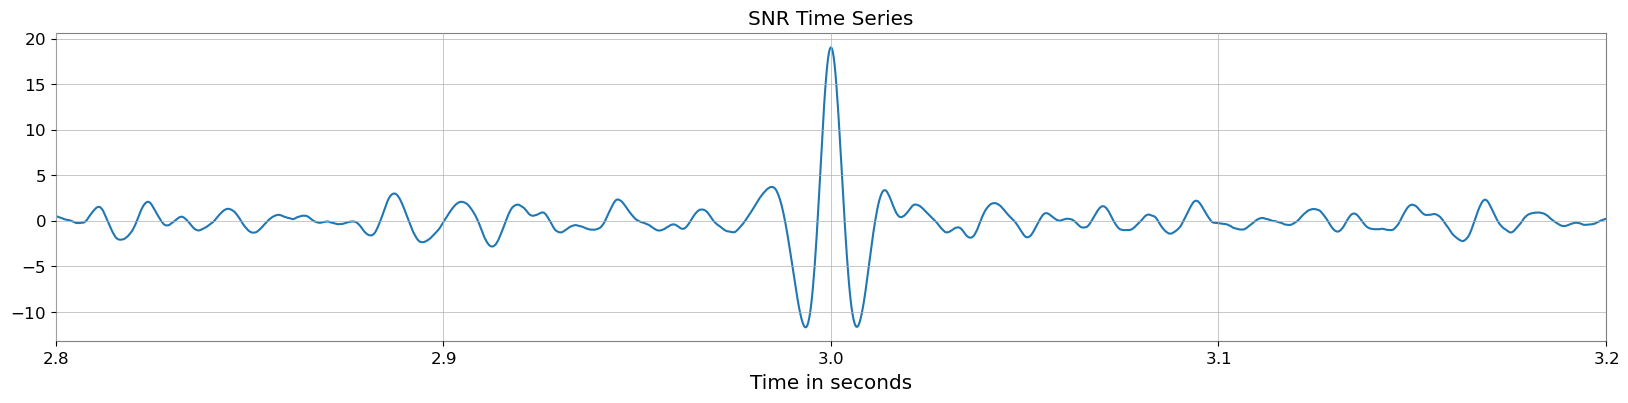

In [27]:
plt.figure(figsize=(20, 4), dpi=100)
plt.plot(snr_timeseries.sample_times, snr_timeseries)
plt.xlim(2.8, 3.2)
plt.xticks(np.arange(2.8, 3.2, 0.1))
plt.title('SNR Time Series')
plt.xlabel('Time in seconds')
plt.show()

### Steps taken till now:

- Randomly generated a glitch from gengli with a sample rate of 4096 (4096 samples per second)
- Generated 10 seconds of white noise with the help of the pycbc package and injected the glitch into it 3 seconds in.
- Generated the timeseries plot and focused on a short timeframe around the glitch to get a clearer view of the curve.


### Doubts

- What does the snr scaling mean? Is it something like ensuring the signal injected is 15 times that of the noise that the glitch would be injected to so that it can easily be differenciated from?
- Is it normal for some glitches to have negative values? And how can negative values be interpreted here? Example:
![image.png](images/image.png)
- Sometimes executing the plotting of the timeseries data gives the following warning (image below). From what I understand, complex numbers are a part of these calculations, however since I have not worked with complex numbers in the context of signals for a very long time, I might need some explanation as to how complex numbers weigh in here.
  ```bash
    ComplexWarning: Casting complex values to real discards the imaginary part
      return math.isfinite(val)
    ComplexWarning: Casting complex values to real discards the imaginary part
      return np.asarray(x, float)

  ```